# Final Model - Rodriguez

Possible explorations:

* Rework Rodriguez - data leakage.
* Data leakage
* Feature importance


**data leakage**

* `FDmean`, `FDmedian`, `FDstd`, `FDvariance`, `FDmin`, `FDmax`, `FDtrimmed_mean`, `FDkurtosis`, `FDskewness`, `FDcoefficient_of_variance`, and `FDinterquartile_range`: All these features are calculated from the psd dataframe, which is derived from the fft_columns dataframe obtained by applying the Fast Fourier Transform (FFT) to the entire dataset using `fft_columns = df.iloc[:, 4:].apply(lambda row: np.fft.fft(row), axis=1)`.
* `FDentropy` and `FDspectral_flatness`: These features are calculated directly from the fft_columns dataframe, which is obtained from the FFT of the entire dataset.
* `FDskewness`: This feature is calculated from the absolute values of the fft_columns dataframe, which involves information from the entire dataset.
* `TDtrimmed_mean`: This feature calculates the trimmed mean by removing values outside the 10th and 90th percentiles. However, these percentiles are calculated based on the entire dataset, including the test set, using `np.percentile(row, 10)` and `np.percentile(row, 90)`.


Therefore, all the `Frequency Domain` features should be calculated after splitting...unless you are generalising from your dataset to the population, which seems foolhardy in this situation. 

## Preprocessing dataset

* extract data
* keep full days only (1440 min per date)
* reduce by 'days' on `scores_csv`

In [1]:
import pandas as pd

# load functions in python file with magic command
%run ../code/final-1-rodriguez.py

In [2]:
# paths
folderpath = '../data/depresjon'
output_csv_path = '../data/petter/final.csv'
scores_csv_path = '../data/depresjon/scores.csv'

# full ds, no csv
df = extract_from_folder(folderpath)

# keep full days only
full_df = preprocess_full_days(df, print_info=False)

# reduce to `num_days` in scores.csv
reduce_df = extract_days_per_scores(full_df, scores_csv_path)


In [3]:
# add scores df
final_scores_df = add_scores(reduce_df, scores_df = pd.read_csv(scores_csv_path))

## drop cols 5, 6, 9-16
final_df = final_scores_df.drop(columns=final_scores_df.columns[[5, 6, 9, 10, 11, 12, 13, 14, 15, 16]],axis=1, inplace=False)

In [4]:
# save to csv
final_df.to_csv('../data/petter/final-rod-1-all.csv', index=False)

## Exploration - Rodriguez with no `data leakage`

* Avoiding data leakage with 14 features used by Rodriguez
* Split into separate datasets before engineering features


In [3]:
import pandas as pd

# load functions in python file with magic command
%run ../code/final-1-rodriguez.py

In [4]:
# import dataset, timestamp, date as datetime
df_rod = pd.read_csv('../data/petter/final-rod-1-all.csv', parse_dates=['timestamp', 'date'])

# drop cols - gender and age
df_rod = df_rod.drop(['gender', 'age'], axis=1)


New shape to dataframe - min/hour columns

In [5]:
# extract hour and minute from timestamp
df_rod['hour'] = df_rod['timestamp'].dt.hour
df_rod['minute'] = df_rod['timestamp'].dt.minute

# pivot the DataFrame
df_pivot = df_rod.pivot(index=['date', 'id', 'label', 'hour'], columns='minute', values='activity')

# rename columns
df_pivot.columns = [f'min_{minute:02d}' for minute in range(60)]

# reset index
df_pivot.reset_index(inplace=True)

In [81]:
#missing = df_pivot[df_pivot.isnull().any(axis=1)]
#print(missing)

New dataframes - day, night, full

In [6]:
#  subsets based on time ranges
day = df_pivot[(df_pivot['hour'] >= 8) & (df_pivot['hour'] < 20)]  # day: 8 am to 8 pm
night = df_pivot[(df_pivot['hour'] >= 21) | (df_pivot['hour'] < 7)]  # night: 9 pm to 7 am
full = df_pivot  # full day:  24 hours

# print shapes
print(day.shape)
print(night.shape)
print(full.shape)

(12348, 64)
(10290, 64)
(24696, 64)


## Features

* Ensure that split into test/train is done before calculating features
* Functions below split the datasets first and then standardise and calculate 14 features. 

### Features and Random Forest model

`preprocess_and_calculate` - for feature generation

`fit_and_evaluate` - for model (Random Forest)

In [7]:
dfs = [day, night, full]
df_names = ['day', 'night', 'full']

In [8]:
# create dictionary to store feature importances
feature_importances = {}
# loop through datasets, fit models
for df, df_names in zip(dfs, df_names):
    print(f'Processing {df_names} dataset')
    X_train, y_train, X_test, y_test = preprocess_and_calculate_features(df)
    print(f'X_train shape: {X_train.shape}')
    print(f'y_train shape: {y_train.shape}')
    print(f'X_test shape: {X_test.shape}')
    print(f'y_test shape: {y_test.shape}')
    print('')
    print(f'Fitting model for {df_names} dataset')
    accuracy, f1, conf_matrix, recall, mcc, precision, roc_auc, specificity, support, feature_importance_dict = fit_and_evaluate(X_train, y_train, X_test, y_test)
    feature_importances[df_names] = feature_importance_dict
    print(f"Accuracy: {accuracy:.4f}, \nF1-score: {f1:.4f}, \nConfusion Matrix:\n{conf_matrix}\nRecall: {recall:.4f}, \nMCC: {mcc:.4f}")
    print("\n")

Processing day dataset
X_train shape: (10200, 23)
y_train shape: (10200,)
X_test shape: (2148, 23)
y_test shape: (2148,)

Fitting model for day dataset
Accuracy: 0.5689, 
F1-score: 0.4154, 
Confusion Matrix:
[[893 271]
 [655 329]]
Recall: 0.3343, 
MCC: 0.1127


Processing night dataset
X_train shape: (8500, 23)
y_train shape: (8500,)
X_test shape: (1790, 23)
y_test shape: (1790,)

Fitting model for night dataset
Accuracy: 0.5011, 
F1-score: 0.3653, 
Confusion Matrix:
[[640 330]
 [563 257]]
Recall: 0.3134, 
MCC: -0.0284


Processing full dataset
X_train shape: (20400, 23)
y_train shape: (20400,)
X_test shape: (4296, 23)
y_test shape: (4296,)

Fitting model for full dataset
Accuracy: 0.5475, 
F1-score: 0.4004, 
Confusion Matrix:
[[1703  625]
 [1319  649]]
Recall: 0.3298, 
MCC: 0.0669




### Interpretation

The above model is a recreation of the Rodriguez model but making sure that there is no data leakage, by standardising and generating features after splitting the datasets into `train` and `test`.

The data was reduced to the 'days' column on 'scores.csv' so there are an uneven number of days - but each day is full - that is, it contains 1440 rows.

Directly comparing to the data leak version: 

**Day**
* Accuracy dropped from 0.7289 to 0.566
* F1 stayed the same around 0.4
* Recall dropped from 0.45 to 0.33
* MCC dropped from 0.22 to 0.1

**Night**
* Accuracy dropped from 0.7095 to 0.5089
* F1 stayed the same around 0.35
* Recall dropped from 0.39 to 0.31
* MCC dropped from 0.17 to -0.009

**Full**
* Accuracy dropped from 0.71 to 0.55
* F1 improved slightly from 0.37 to 0.4
* Recall dropped from 0.42 to 0.33
* MCC dropped from 0.19 to 0.06


**It is clear that the methodology employed by the authors of this study introduced significant data leakage, even more than I was able to introduce given their reported accuracy of 0.99**

Model with data leakage can be found here: 

[..\petter\Rodriguez-recreation.ipynb](..\petter\Rodriguez-recreation.ipynb)

### Variable Importance

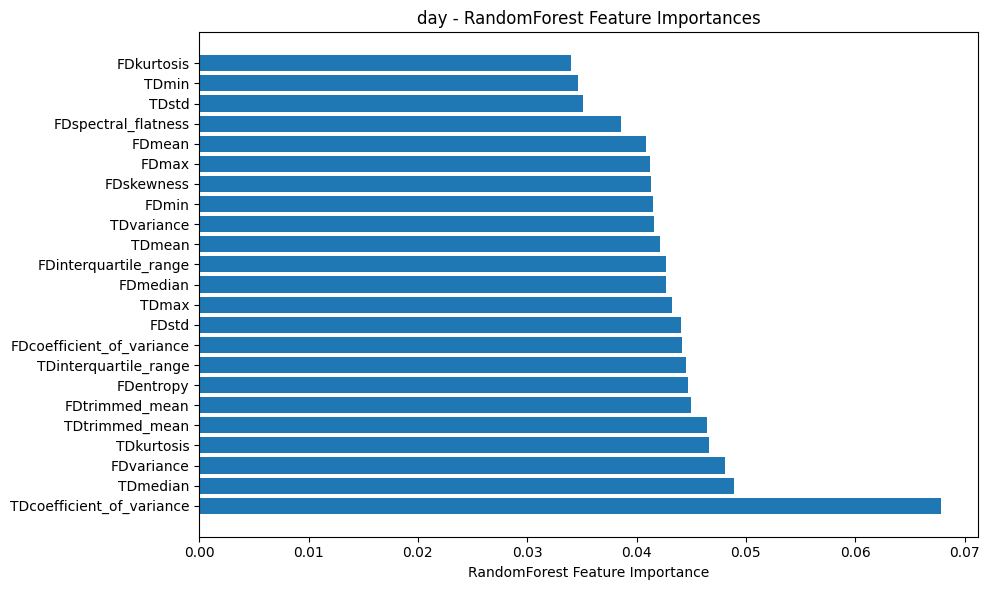

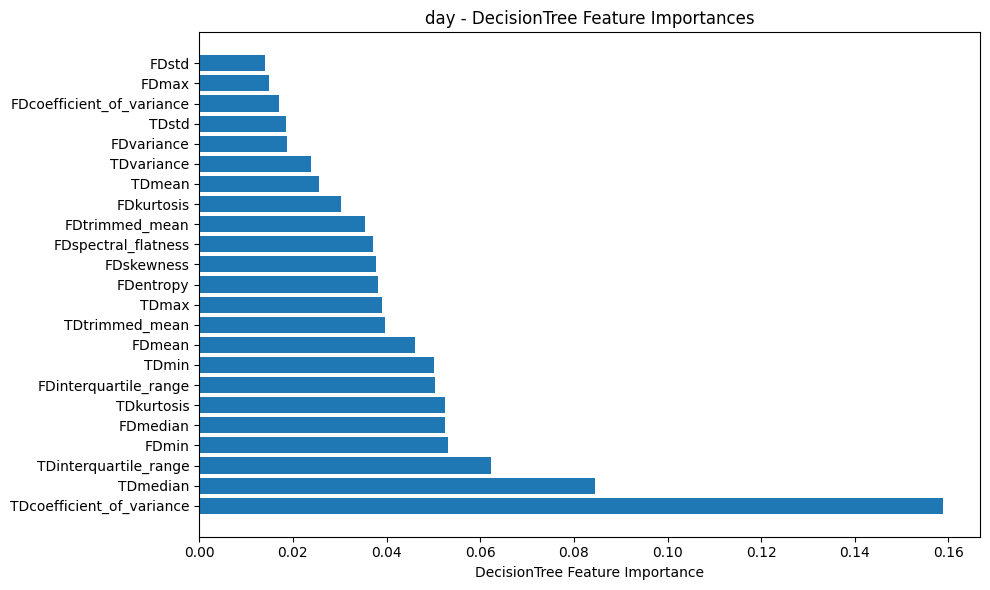

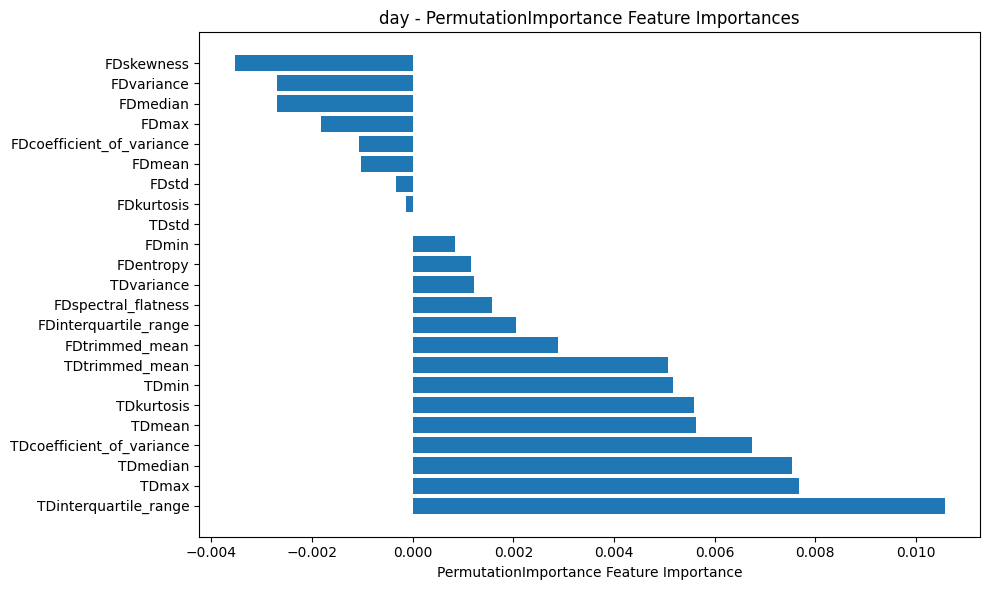

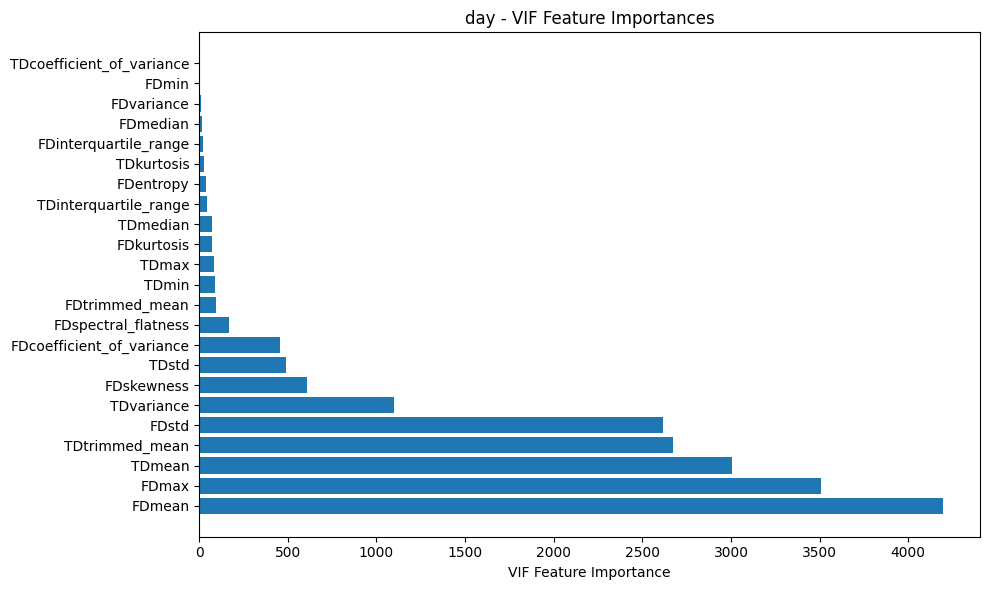

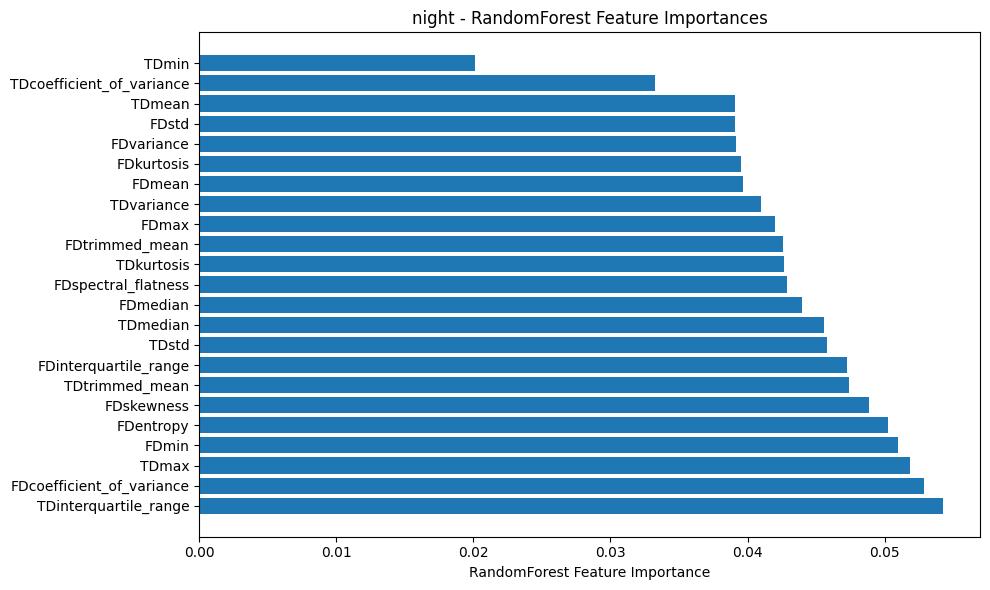

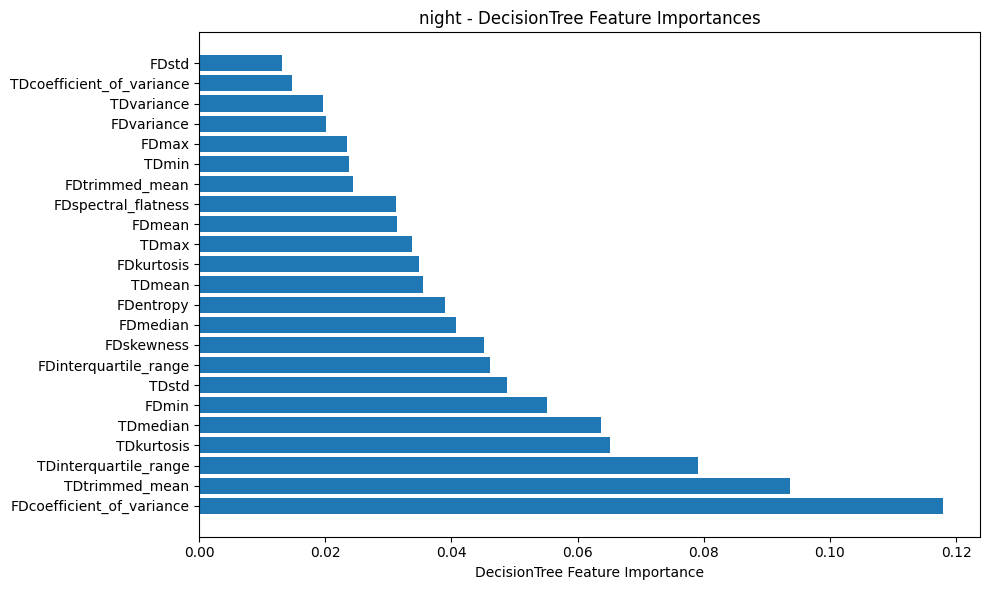

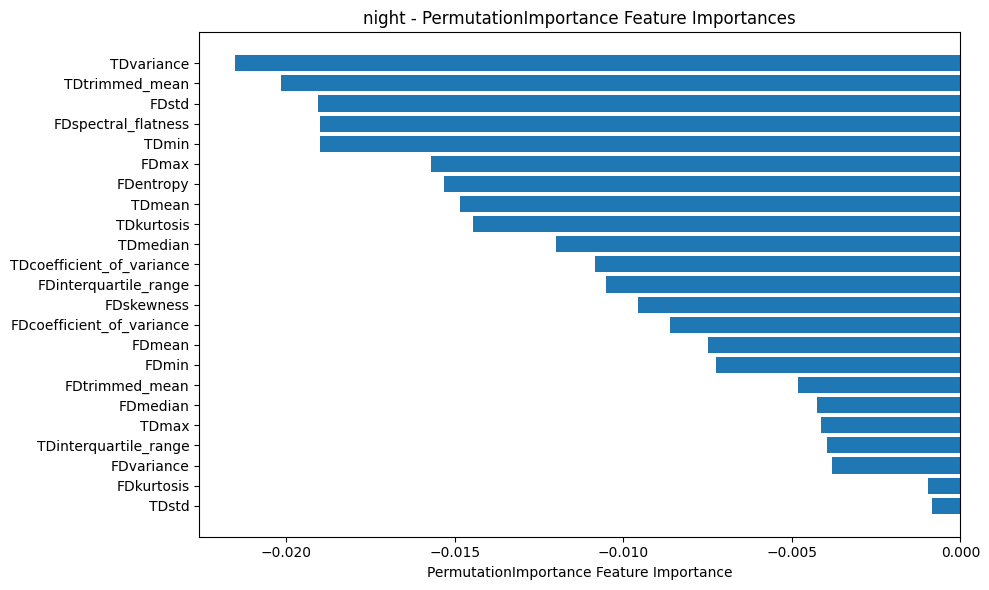

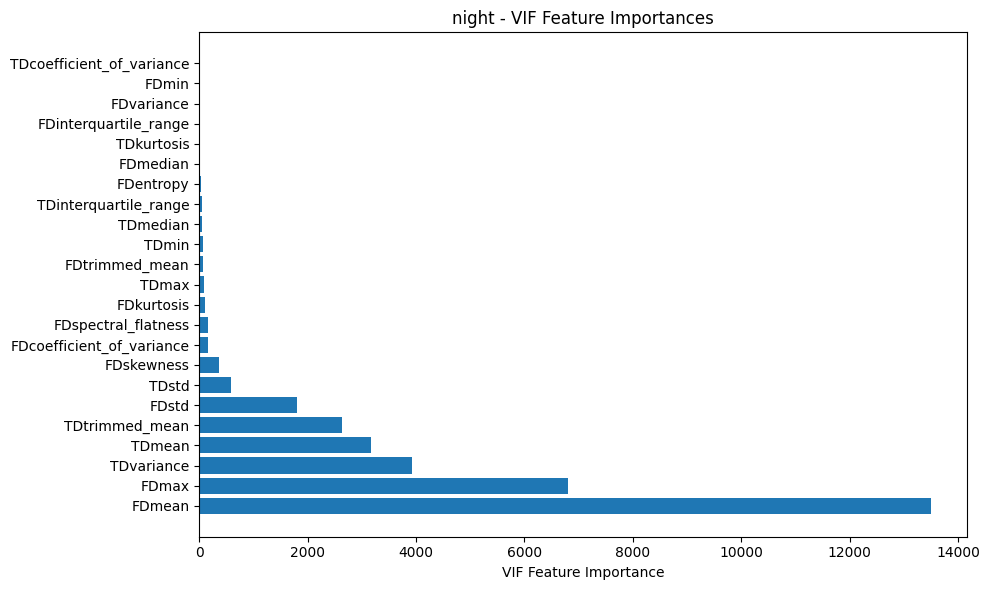

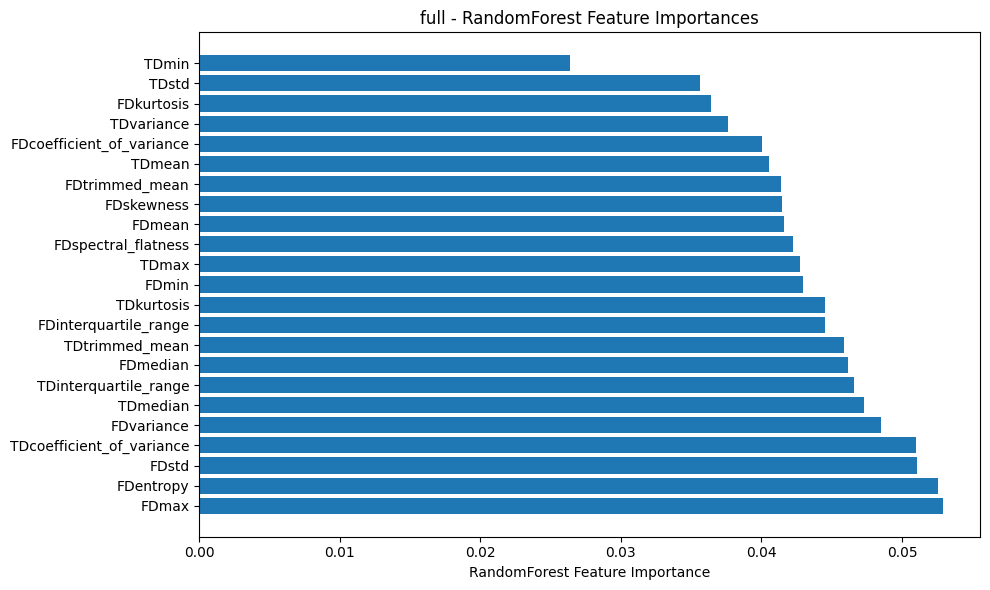

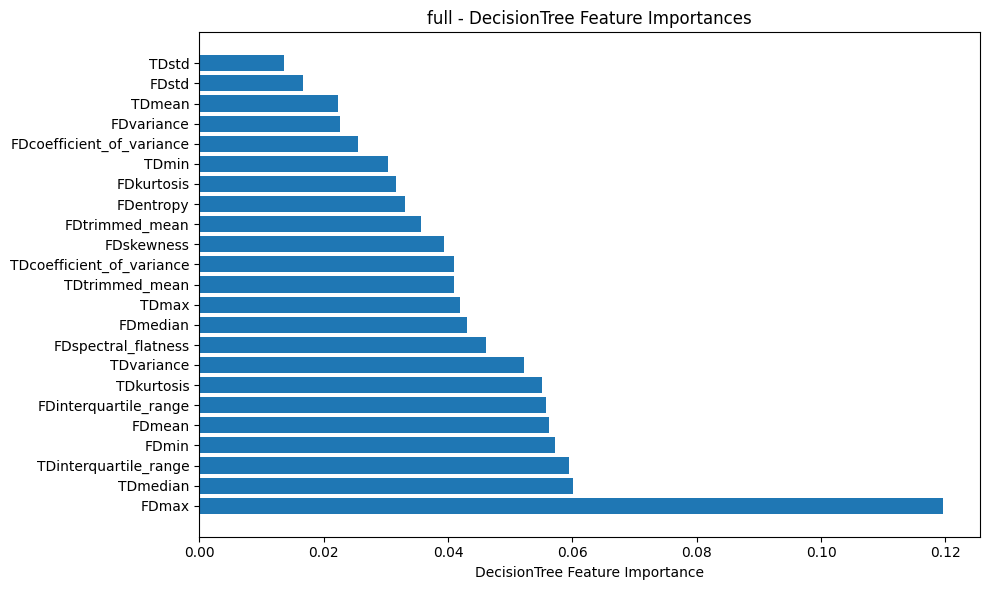

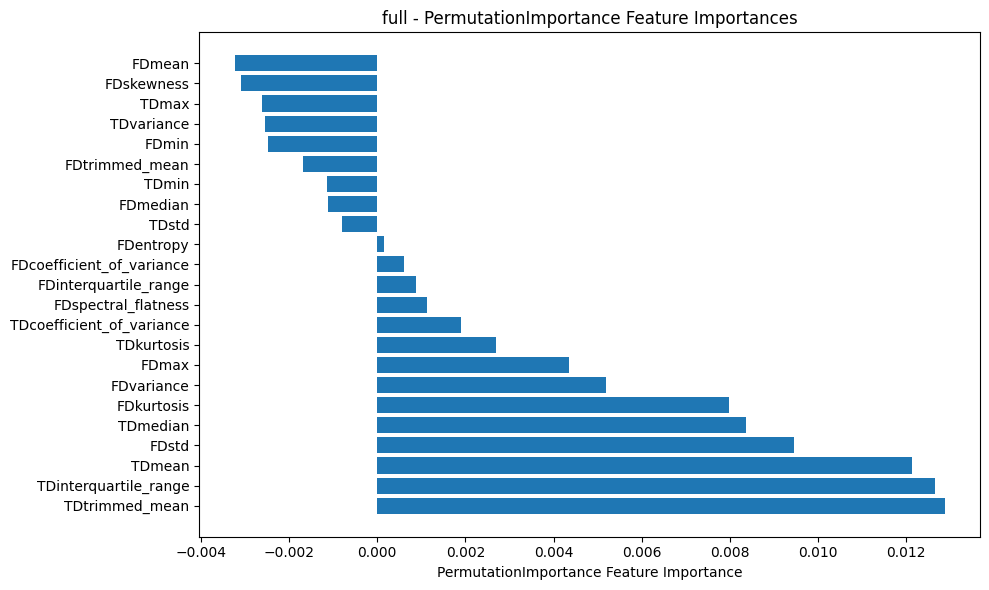

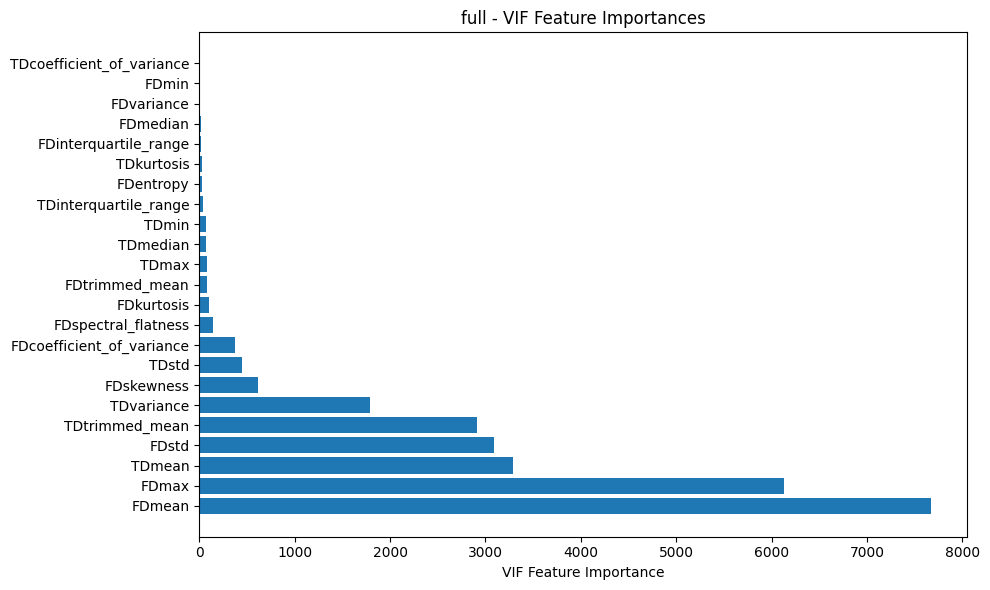

In [9]:
# feature importance metrics for each dataset
for df_name, importance_dict in feature_importances.items():
    for metric in ['RandomForest', 'DecisionTree', 'PermutationImportance', 'VIF']:
        plot_feature_importances(df_name, metric, importance_dict)

### Variable importance interpretation

* **Random Forest Feature Importance**
  * higher values are more important for the RF prediction based on how much of the accuracy decreases if the feature is permuted (randomly shuffled)
  * **day**
    * `TDcoefficient_of_variance`, `TDkurtosis`, `FDvariance` are top three
  * **night**
    * `TDinterquartile_range`, `FDentropy`, `TDtrimmed_mean` are top three
  * **full**
    * `TDcoefficient_of_variance`, `FDvariance`, `FDstd` are top three
* **Decision Tree Feature Importance**
  * higher values are more important for the DT prediction based on how much each feature contributes to reducing 'impurity' (Gini) at each node of the tree
  * **day**
    * `TDcoefficient_of_variance`, `TDmedian`, `TDinterquartile_range` are top three
  * **night**
    * `FDcoefficient_of_variance`, `TDtrimmed_mean`, `TDinterquartile_range` are top three
  * **full**
    * `FDmax`, `TDmedian`, `FDmin` are top three
* **Permutation Importance Feature Importance**
  * can be positive or negative
  * positive values indicate that permuting (randomly shuffling) this feature decreases the model's performance, making it an important feature
  * negative values suggest that permuting the feature may slightly improve the model's performance, suggesting that the feature is *noisy* or *redundant*
  * **day**
    * negative -> `TDkurtosis`, `FDstd`, `FDmax`
    * positive (top 3) -> `TDmin`, `TDinterquartile_range`, `TDmean`
  * **night** 
    * negative (top 3) -> `TDvariance`, `TDtrimmed_mean`,`FDvariance` and more
    * positive (top 3) -> `FDmedian`, `FDmax`, `TDcoefficient_of_variance`
  * **full**
    * negative (top 3) -> `FDkurtosis`, `FDspectral_flatness`, `FDskewness`
    * positive (top 3) -> `TDtrimmed_mean`, `TDstd`, `TDinterquartile_range`
* **Variance Inflation Factor (VIF)**
  * higher values indicate higher multicollinearity between features
  * VIF value greater than 5 or 10 is often considered problematic - remove or combine
  *  **day**
    * `TDcoefficient_of_variance`, `FDmin` are only features < 10 VIF
  * **night**
    * `TDcoefficient_of_variance`, `FDvariance` and `FDmin` are only features < 10 VIF
  * **full**
    * `TDcoefficient_of_variance`, `FDvariance` and `FDmin` are only features < 10 VIF

In [11]:
# print VIF scores which are greater than 10
for df_name, importance_dict in feature_importances.items():
    print(f'VIF scores for {df_name} dataset')
    for feature, vif in importance_dict['VIF'].items():
        if vif < 10:
            print(f'{feature}: {vif:.4f}')
    print('\n')

VIF scores for day dataset
TDcoefficient_of_variance: 1.0031
FDmin: 2.1116


VIF scores for night dataset
TDcoefficient_of_variance: 1.0043
FDvariance: 4.5546
FDmin: 2.2609


VIF scores for full dataset
TDcoefficient_of_variance: 1.0019
FDvariance: 9.3218
FDmin: 1.8627


